In [15]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
protoFile = 'Model/pose_deploy_linevec.prototxt'
weightsFile = 'Model/pose_iter_440000.caffemodel'

In [3]:
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

In [32]:
imgpath1 = 'Image/00035.jpg'
imgpath2 = 'Image/00036.jpg'
frame1 = cv2.imread(imgpath1)
frame2 = cv2.imread(imgpath2)
inWidth = 368
inHeight = 368
frames = []
frames.append(frame1)
frames.append(frame2)
inBlob = cv2.dnn.blobFromImages(frames, 1.0/255, (inWidth, inHeight), (0,0,0), swapRB=False, crop=False)
net.setInput(inBlob)

In [33]:
output = net.forward()

In [34]:
output.shape

(2, 57, 46, 46)

In [36]:
# outH = output.shape[2]
# outW = output.shape[3]
# keypt = output.shape[1]

# points = []
# for i in range(output.shape[1]):
#     probMap = output[0,i,:,:]
#     minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
#     x = (frameWidth * point[0]) / outW
#     y = (frameWidth)

frameHeight, frameWidth, _ = frame.shape
print(output[0][0][:].shape)

(46, 46)


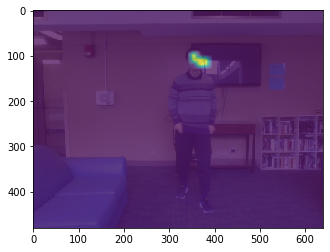

In [28]:
probMap = output[0,-1,:,:]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.7)